In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/Academics/Machine Learning /Project")
!ls

 aapl_loss.PNG		      'Final Report.gdoc'
 aapl_loss.txt		       googl_loss.PNG
 aapl.us.csv		       googl_loss.txt
 amzn_loss.PNG		       LinearRegressionModel.ipynb
 amzn_loss.txt		       msft_loss.PNG
 ConvolutionalAlgo.ipynb       msft_loss.txt
 Covolution2.ipynb	       Tasks.gdoc
 Datasets		      'Zoom 2020-05-06 09-06-46.mp4'
'Final Presentation.gslides'


In [0]:
import numpy as np
import pandas as pd
import scipy.signal # Has useful routines for 2D convolutions.
import skimage.data # Sub-package for getting some basic images.
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

In [0]:
def create_dly_data(X,y,dly, days):
    """
    Create delayed data
    """
    Xdly = []
    # X tranformation
    for i in range(dly-days,X.shape[0]-days):
      row = np.array([])
      j = 0
      while j != dly:
        row = np.hstack([X.iloc[i-j,:],row])
        j+=1
      Xdly.append(row)
    Xdly = np.array(Xdly)

    # Y transformation
    ydly = []
    for i in range(dly,y.shape[0]):
      ydly.append(y[i])
    ydly = np.array(ydly)

    return Xdly, ydly

In [0]:
X = pd.read_csv('Datasets/msft.us.csv', header=0).loc[:,("Open","High","Low","Volume")]
y = pd.read_csv('Datasets/msft.us.csv', header=0).loc[:, "Close"]
# print("Microsoft stocks:")
# Xdly, ydly = create_dly_data(X, y, 7, 1)
# Xtr, Xts, ytr, yts = train_test_split(Xdly,ydly,test_size=0.30, shuffle=False)

In [0]:
def create_mod(delay, use_dropout=False, use_bn=False):
  model = Sequential()
  model.add(Conv1D(12, 3, padding='valid', activation='relu',
                     input_shape=(delay*4,1)))
  model.add(MaxPooling1D(pool_size=2))
  if use_bn:
    model.add(BatchNormalization())
  # model.add(Conv1D(32, 3, activation='relu', input_shapes=))
  # model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  if use_bn:
      model.add(BatchNormalization())
  if use_dropout:
      model.add(Dropout(0.5))
  model.add(Dense(25, activation = 'relu'))
  if use_bn:
      model.add(BatchNormalization())
  if use_dropout:
      model.add(Dropout(0.5))
  model.add(Dense(1))
  
  return model

In [0]:
# Parameters
nepochs = 200
batch_size = 32
lr = 1e-3
decay = 1e-4

In [0]:
one_day2 = []
seven_day2 = []
fourteen_day2 = []
# twenty_one_day = []
# twenty_eight_day = []
intervals = [1,7,14]
for interval in intervals:
  for i in range(1,30):
    Xdly, ydly = create_dly_data(X, y, i, interval)
    Xtr, Xts, ytr, yts = train_test_split(Xdly,ydly,test_size=0.30, shuffle=False)
    K.clear_session()

    model1 = create_mod(i, use_bn=True)
    # model2 = create_mod(delay=i, interval=7)
    # model3 = create_mod(delay=i, interval=14)

    # Create the optimizer
    opt = optimizers.RMSprop(lr=lr, decay=decay)

    # Compile
    hist1 = model1.compile(loss='mae', optimizer=opt)
    # hist2 = mode2.compile(loss='mae', optimizer=opt)
    # hist3 = mode3.compile(loss='mae', optimizer=opt)
    print(model1.summary())
    # print(model2.summary())
    # print(model3.summary())

    # Fit the model
    X_reshaped1 = Xtr.reshape((Xtr.shape[0], Xtr.shape[1], 1))
    X_reshaped2 = Xts.reshape((Xts.shape[0], Xts.shape[1], 1))
    hist = model1.fit(X_reshaped1, ytr, epochs=nepochs)
    yhat1 = model1.predict(X_reshaped2)
    loss = np.mean(np.abs(yhat1 - yts))

    train_loss = hist.history["loss"].pop()
    if interval == 1:
      one_day2.append((train_loss, loss, yhat1, yts))
    if interval == 7:
      seven_day2.append((train_loss, loss, yhat1, yts))
    if interval == 14:
      fourteen_day2.append((train_loss, loss, yhat1, yts))


(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 <a list of 10 Text major ticklabel objects>)

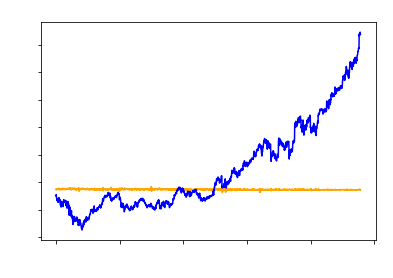

In [28]:
min_val=min(one_day2, key= lambda x: x[1])
x_vals = np.linspace(0,len(min_val[2])-1, len(min_val[2]))
x_vals2 = np.linspace(0,len(min_val[3])-1, len(min_val[3]))
plt.plot(x_vals, min_val[2], c="orange")
plt.plot(x_vals2, min_val[3], c="blue")
plt.xlabel("Days", c="white")
plt.ylabel("Price", c="white")
plt.title("Microsoft", c="white");
plt.xticks(c="white")
plt.yticks(c="white")

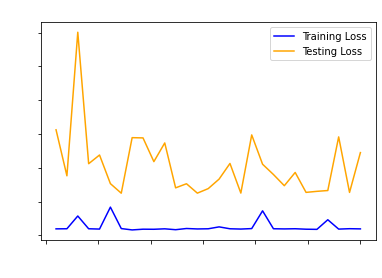

In [26]:
x_vals = np.linspace(1,30,29)
y_vals = [val[1] for val in one_day2]
y_train = [val[0] for val in one_day2]
plt.plot(x_vals, y_train, c="blue");
plt.plot(x_vals, y_vals, c="orange");
plt.xlabel("Interval", c="white")
plt.ylabel("Loss", c="white")
plt.xticks(c="white")
plt.yticks(c="white")
plt.title("Microsoft best loss", c="white");
plt.legend(["Training Loss", "Testing Loss"]);

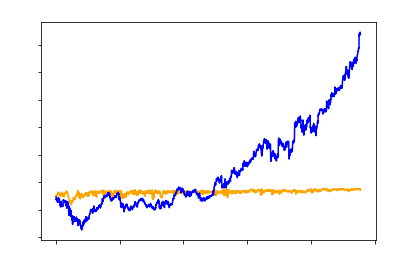

In [27]:
min_val=min(seven_day2, key= lambda x: x[1])
x_vals = np.linspace(0,len(min_val[2])-1, len(min_val[2]))
x_vals2 = np.linspace(0,len(min_val[3])-1, len(min_val[3]))
plt.plot(x_vals, min_val[2], c="orange")
plt.plot(x_vals2, min_val[3], c="blue")
plt.xlabel("Days", c="white")
plt.ylabel("Price", c="white")
plt.title("Microsoft", c="white")
plt.xticks(c="white")
plt.yticks(c="white");

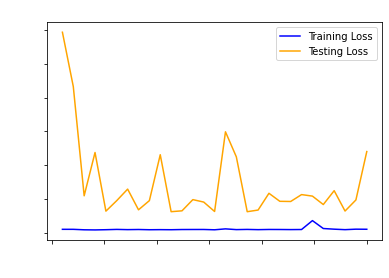

In [25]:
x_vals = np.linspace(1,30,29)
y_vals = [val[1] for val in seven_day2]
y_train = [val[0] for val in seven_day2]
plt.plot(x_vals, y_train, c="blue");
plt.plot(x_vals, y_vals, c="orange");
plt.xlabel("Interval", c="white")
plt.ylabel("Loss", c="white")
plt.xticks(c="white")
plt.yticks(c="white")
plt.title("Microsoft best loss", c="white");
plt.legend(["Training Loss", "Testing Loss"]);

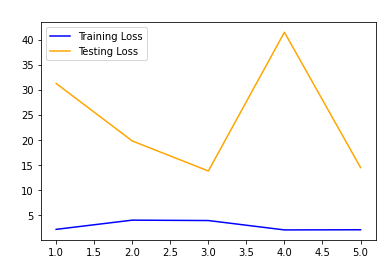

In [24]:
x_vals = np.linspace(1,5,5)
y_vals = [val[1] for val in fourteen_day2]
y_train = [val[0] for val in fourteen_day2]
plt.plot(x_vals, y_train, c="blue");
plt.plot(x_vals, y_vals, c="orange");
plt.xlabel("Interval", c="white")
plt.ylabel("Loss", c="white")
# plt.xticks(c="white")
# plt.yticks(c="white")
plt.title("Microsoft best loss", c="white");
plt.legend(["Training Loss", "Testing Loss"]);

In [17]:
Xdly, ydly = create_dly_data(X, y, 10, 7)
Xtr, Xts, ytr, yts = train_test_split(Xdly,ydly,test_size=0.30, shuffle=False)
K.clear_session()

model1 = create_mod(10, use_bn=True, use_dropout=True)
# model2 = create_mod(delay=i, interval=7)
# model3 = create_mod(delay=i, interval=14)

# Create the optimizer
opt = optimizers.RMSprop(lr=lr, decay=decay)

# Compile
hist1 = model1.compile(loss='mae', optimizer=opt)
# hist2 = mode2.compile(loss='mae', optimizer=opt)
# hist3 = mode3.compile(loss='mae', optimizer=opt)
print(model1.summary())
# print(model2.summary())
# print(model3.summary())

# Fit the model
X_reshaped1 = Xtr.reshape((Xtr.shape[0], Xtr.shape[1], 1))
X_reshaped2 = Xts.reshape((Xts.shape[0], Xts.shape[1], 1))
hist = model1.fit(X_reshaped1, ytr, epochs=nepochs)
yhat1 = model1.predict(X_reshaped2)
loss = np.mean(np.abs(yhat1 - yts))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 38, 12)            48        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 12)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 12)            48        
_________________________________________________________________
flatten (Flatten)            (None, 228)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 228)               912       
_________________________________________________________________
dropout (Dropout)            (None, 228)               0         
_________________________________________________________________
dense (Dense)                (None, 25)                5

In [18]:
loss

117.82119989508699